# 7. Analiza skupień (klasteryzacja)


Zadaniem **analizy skupień** (ang. *clustering*) jest znalezienie naturalnych zgrupowań danych, w których elementy danej grupy (klastra) wykazują większe podobieństwo wzajemne od elementów innej grupy. Grupowanie odbywa się wyłącznie na podstawie informacji zawartych w zmiennych opisujących obiekty. W przypadku  metod klasyfikacji lub regresji, które poznaliśmy na poprzednich zajęciach, dla każdego wektora treningowego posiadaliśmy informację o pożądanej wartości wyjściowej (np. etykiecie klasy). Są to tzw. metody **nadzorowane** (*supervised*), gdyż proces uczenia może być w każdym momencie oceniony a informacja o błedach jest wykorzystywana do skorygowania modelu w celu minimalizacji tego błędu. W analizie skupień nie posiadamy takiej informacji zwrotnej, dlatego takie metody nazywamy **nienadzorowanymi** (*unsupervised*). Przyporządkowanie do grup (klastrów) a nawet ilość tych grup jest informacją, którą klasteryzacja ma za zadanie odkryć.

Notatnik przybliża zasady działania następujących metod analizy skupień: 
* metoda k-średnich 
* grupowanie hierarchiczne
* grupowanie gęstościowe (metoda DBSCAN)




## Metoda k-średnich (K-means)

Metoda $k$-średnich reprezentuje każdą grupę za pomocą prototypu (centroidy). Dane dzielone są na $k$ rozdzielnych grup, gdzie każdy obiekt danych wejściowych jest przypisany do jednaj z $k$ centroid znajdującej się w najmniejszej odległości od tego obiektu. 

Dla danych $k$ prototypów algorytm znajdowania grup sprowadza się do powtarzania iteracyjnego następujących kroków:
1. Przydziel każdą próbkę $\vec{x}$ do najbliższej centroidy
2. Wyznacz środek punktów przydzielonych do centroidy i przesuń tam centroidę

Budując model należy najpierw określić liczbę klastrów $k$ oraz wybrać miarę określającą podobieństwo obiektów, czyli metrykę. Przykładem może być odległość Euklidesa 

$$ d(\vec{x}, \vec{y}) = \sum_{i=1}^d (x_i - y_i)^2 $$

Początkowe pozycje centroid są losowe (można wybrać w tym celu  $k$ losowych próbek ze zbioru uczącego). Pozycja startowa ma wpływ na uzyskany wynik, więc ponowne uruchomienie algorytmu może zaowocować uzyskaniem odmiennego podziału.  Może też się zdarzyć, że losowo umieszczony prototyp nie posiada żadnego obiektu w swoim zasięgu, więc sposób inicjowania pozycji prototypów jest tu istotny.


## Generowanie sztucznych  danych 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ustalmy ziarno losowania aby oblicznia były powtarzalne
np.random.seed(8)

# wylosujmy środki losowanych grup (k=3)
centrs = np.random.rand(3,2)

# ilość wektorów w grupie
num = 50
std = 0.07

#wylosujmy zbiór punktów z rozkładu normalnego
X = np.vstack([
    np.random.normal(centrs[0], [std, std], (num, 2)),
    np.random.normal(centrs[1], [std, std], (num, 2)),
    np.random.normal(centrs[2], [std, std], (num, 2)),
                 ])

plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolor='black', s=50)
plt.grid()
plt.show()

Wygenerowane dane składają się z 3 grup puntów, jednak załóżmy, że tego nie wiemy a algorytm k-średnich posłuży nam aby odkryć te skupiska. 

Sprobujmy pogrupować dane na 3 klastry. Wylosujmy położenia 3 wektorów prototypowych.

In [ ]:
np.random.seed(3)
k = 3 
C = np.random.rand(k, 2)

# narysujmy pozycje prototypów
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolor='black', s=50, label='Punkty danych')
plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Przypiszmy każdy wektor danych wejściowych do najbliższego prototypu stosując odległość Euklidesową.

In [ ]:
from scipy.spatial import distance  # pakiet do obliczeń odległości

y = np.zeros(len(X))   # wektor przypisujący indeks próbki -> indeks centroidy (grupy)
for i, s_i in enumerate(X):
    dists = []
    for c_i in C:
        dists.append(distance.euclidean(s_i, c_i ))
    y[i] = np.argmin(dists)    # przypiszmy indeks najbliższej centroidy
    
# i narysujmy wykres rozrzutu z pogrupowanymi danymi
for i in range(len(C)):
    plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Poniższa komórka robi dokładnie to samo ale używa nieco bardziej zoptymalizowanej formy zastępując pętlę pythona  odpowiednimi funkcjami z bibliotek scipy i numpy

In [ ]:
# funkcja cdist() wyznacza odległości pomiędzy wszystkimi parami wektorów (wierszy) X i C
dists = distance.cdist(X, C, metric='euclidean')

# wyznaczamy wektor indeksów najbliższych prototypów
y = np.argmin(dists, axis=1) # wykonaj funkcje argmin 'po wierszach' (czyli os numer 1)

for i in range(len(C)):
    plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Początkowe pozycje centroid zostały wybrane losowo, więc podział jest daleki od idealnego.

Dokonajmy aktualizacji położeń prototypów przesuwając je w środek punktów należących do grupy wektorów przypisanych poszczególnym prototypom

In [ ]:
C_old = C.copy()

# wyznaczenie środka grup
for i in range(len(C)):
    C[i] = np.mean(X[y==i], axis=0)

dists = distance.cdist(X, C, metric='euclidean')
y = np.argmin(dists, axis=1) 
    
for i in range(len(C)):
    plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
plt.scatter(C_old[:, 0], C_old[:, 1], marker='*', c='blue', edgecolor='black', label='Poprzednie położenie', s=200)
plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Uruchommy kilkukrotnie oba kroki, tzn. podział na grupy i aktualizację położenia centroid.

In [ ]:
np.random.seed(3)
k = 3 
C = np.random.rand(k, 2)

for k in range(5):
    
    # podzial wektorow na grupy
    dists = distance.cdist(X, C, metric='euclidean')
    y = np.argmin(dists, axis=1) 
    
    print('Krok %d, średnia odległość od centroidy = %.3f' % (k+1, np.mean(np.min(dists, axis=1))))
    
    # aktualizacja pozycji
    for j in range(len(C)):
        C[j] = np.mean(X[y==j], axis=0)

    # rysowanie wykresu
    for i in range(len(C)):
        plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
    plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

Widać, że algorytm się zbiega i po pewnym czasie można oczekiwać, że położenia centroid przestaną się zmieniać. 

Algorytm gotowy, zapiszmy go w postaci funkcji ``kmeans``.  
Funkcja przyjmuje następujące argumenty: 
* `X` dane wejściowe, 
* `k` ilość grup, 
* `max_iter` maksymalna ilość kroków, 
* `min_improvement` określa miejsce przerwania, gdy kolejna aktualizacja będzie mniejsza od tego progu.  

Funkcja zwraca dwie wartości: 
* wektor `y` określający przynależność każdego przypadku z `X` do jednej z `k` grup, 
* macierz `C` zawierającą położenia centroid

In [ ]:
def kmeans(X, k, max_iters = 100, min_improvement=0.01):
    prev_dist = 0
    
    # inicjalizacja centroid, ustawmy początkowe położenie prototypów w miejsc k wylosowanych
    # wektorów z X, w ten sposób gwarantujemy, że każdy centroid ma przynajmniej jeden najbliższy 
    # wektor treningowy
    idx = np.random.choice(len(X), k)
    C = X[idx, :].copy()
    dists = distance.cdist(X, C, metric='euclidean')
    y = np.argmin(dists, axis=1) 
    
    for x in range(max_iters):
        
        for i in range(len(C)):
            if len(X[y==i]) > 0:
                C[i] = np.mean(X[y==i], axis=0)
        
        dists = distance.cdist(X, C, metric='euclidean')
        y = np.argmin(dists, axis=1) 
        
        curr_dist = np.mean(np.min(dists, axis=1))
        
        if curr_dist - prev_dist < min_improvement:
            break  # jeśli nie robimy już poprawek po co kontynuować

    return y, C       

Zobaczmy jak sprawuje się nasz algorytm dla różnych wartości `k`.

In [ ]:
# K-średnich dla k=2

for k in [2, 3, 4]:
    y, C = kmeans(X, k=2)
    for i in range(len(C)):
        plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
    plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
    plt.legend(scatterpoints=1)
    plt.title('k-means (k=%d)' % k)
    plt.grid()
    plt.show()

Podstawowym problemem metody $k$-średnich jest odpowiedni wybór wartości $k$. Zazwyczaj nie wiemy jaka będzie optymalna wartość. W powyższych 3 uruchomieniach algorytmu dla $k=2,3,4$ z uzyskanych wykresów widać, że podział na 4 grupy jest nieuzasadniony. Dodatkowo, dwie chmury punktów widoczne na wykresie po prawej mogą być równie dobrze uważane za pojedynczy klaster. W przypadku wielowymiarowych danych, gdzie nie jesteśmy w stanie wizualnie określić jakości podziału, dobór odpowiedniej wartości `k` możemy wykonać za pomocą **metody łokcia**. 

## Metoda łokcia

Metoda łokcia polega na stworzeniu wykresu zależności `k` od wartości zniekształcenia zdefiniowanego jako suma odległości punktów z grupy od swojej centroidy. Zniekształcenie to zwane jest **wewnątrzgrupową sumą kwadratów błędów** (SSE, *within-cluster sum of squared errors*) lub **bezwładnością klastra**.

$$SSE = \sum_{i=1}^n \sum_{j=1}^k \delta_{ij}\big|\big|\vec{x}^{(i)} - \vec{c}^{(j)}\big|\big|^2$$
gdzie $\delta_{ij}=1$, gdy obiekt $\vec{x}^{(i)}$ nalezy do grupy określonej przez centroid $\vec{c}^{(j)}$. W przeciwnym razie $\delta_{ij}=0$.

Im mniejsza jest wartość zniekształcenia SSE tym bardziej zwarte są klastry, tzn. odległość punktów do centroid jest mała. 
Łatwo zauważyć, że ze wzrostem ilości centroid `k` wartość SSE będzie malała. W ekstremalnym przypadku, gdyby liczba centroid równała się liczbie przypadków treningowych i każdy z nich tworzyłby swoją grupę, otrzymujemy $SSE=0$. 

Jeżeli wykreślimy zależność `k` od SSE dla metody k-średnich to możemy określić miejsce w którym wartość SSE najmocniej wzrasta (_łokieć_ na wykresie), tam znajduje się dobra wartość $k$. 

In [ ]:
numClusters = [1, 2, 3, 4, 5, 6]
SSE = []

for k in numClusters:
   y, C = kmeans(X, k=k)
   dists = distance.cdist(X, C, metric='euclidean')
   sse = np.sum(np.min(dists, axis=1))
   SSE.append(sse)

plt.plot(numClusters, SSE)
plt.xlabel('Ilość grup')
plt.ylabel('SSE')
plt.show()

W tym przypadku wartość $k=3$ jest odpowiednia, to tu zgina się _łokieć_. Dodanie kolejnych centroid nie zmniejsza istotnie SSE, więc nowe klastery (dla k>3) nie wnoszą istotnej informacji.

## k-średnich w scikit-learn

Algorytm $k$-średnich jest też zaimplementowany w pakiecie `scikit-learn`. Do  dyspozycji mamy klasę  `sklearn.cluster.KMeans`.
Dopasowanie modelu na danych treningowych sprowadza się do wywołania metody `fit()` tak samo jak to było w przypadku metod regresji i klasyfikacji. 
Argument `n_init=10` powoduje 10-cio krotne powtórzenie algorytmu z różnymi początkowymi położeniami centroid. Ostatecznie wybierany jest z tych 10-ciu podział o najmniejszym SSE.



In [ ]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3, n_init=10)

# dopasowanie modelu do danych
k_means.fit(X)

# położenie centroid
C = k_means.cluster_centers_

# wartość zniekształcenia SSE
SSE = k_means.inertia_

# przypisanie do grup 
y = k_means.fit_predict(X)

for i in range(len(C)):
    plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Ponownie zastosujmy metodę łokcia dla tego algorytmu

In [ ]:
from sklearn.cluster import KMeans

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10)
    k_means.fit(X)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Ilość grup')
plt.ylabel('SSE')
plt.show()


## Grupowanie hierarchiczne

**Metody hierarchiczne** nie wymagają odgórnego ustalenia liczby klastrów `k` lecz polegają na przyrostowym tworzeniu podziałów na grupy. Skupmy się na podejściu **aglomeracyjnym** (*agglomerative*), czyli wzrostowym. Metoda ta rozpoczyna od przydzielenia każdej próbki do osobnego klastra. Następnie dwa najbardziej podobne skupiska łączymy w jedną grupę. Powtarzamy tę procedurę, aż do momentu uzyskania pojedynczego klastra zawierającego wszystkie przypadki. W ten sposób uzyskujemy drzewo klastrów, które możemy zwizualizaować za pomocą **dendrogramu**, wykresu drzewa podziałów. Poniższy obrazek prezentuje sposób hierarchicznego łączenia próbek w klastry. Ostatni rysunek prezentuje wynikowe drzewo - dendrogram.

![image.png](attachment:image.png)

## Miary podobieństwa klastrów

W zależności od sposobu określania podobieństwa między skupiskami możemy wyróżnić różne odmiany klasteryzacji hierarchicznej. 
Przyjrzyjmy się 3 podstawowym podejściom:
1. **metoda pojedynczego wiązania** (*single link*), gdzie odległość miedzy skupiskami określona jest przez minimalną odległość pomiędzy parą przypadków z różnych grup. Skuteczna dla wyraźnie oddzielonych grup.
2. **metoda pełnego wiązania** (*complete link*), gdzie odległość między klastrami zależy od największej odległości między parami przypadków. Problemy, gdy wystepują dane ostające.
3. **metoda średnich połączeń** (*group average*), odległość mierzona między środkami punktów zawartych w klastrach

Poniższy rysunek obrazuje różnicę między metodą pojedynczego wiązania a metodą pełnego wiązania.

<div>
<img src="attachment:image.png" width="500"/>
</div>

## Dane: sejm 2019

Tym razem wykorzystajmy do grupowania dane pochodzące ze strony Państwowej Komisji Wyborczej zawierające procentowe wyniki uzyskane przez komitety wyborcze w wyborach do Sejmu w 2019 roku. Plik z danymi znajduje się pod adresem https://www.fizyka.umk.pl/~grochu/wdm/files/sejm_2019.csv


In [ ]:
import pandas as pd
sejm = pd.read_csv('https://www.fizyka.umk.pl/~grochu/wdm/files/sejm_2019.csv')
sejm

Weźmy do analizy tylko wyniki procentowe komitetów wyborczych (kolumny od 8 do 18) i sprawdźmy, jak grupują się wyniki dla województw.

In [ ]:
X = sejm.iloc[:, 8:]
labels = sejm.Województwo.tolist()
X

### Metoda pojedynczego wiązania

Tym razem użyjemy implementacji algorytmu dostępnego w pakiecie `scipy`. Stworzenie modelu wymaga uruchomienie funkcji [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).
Wartością zwracaną z tej funkcji jest macierz wiązania, którą możemy użyć jako argument funkcji [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) do zwizualizowania drzewa skupień

In [ ]:
from  scipy.cluster import hierarchy 

Z = hierarchy.linkage(X, 'single')
plt.figure(figsize=(10,6))
dn = hierarchy.dendrogram(Z, labels=labels, orientation='right')

Wartości na osi poziomej to odległości pomiędzy klastrami. W zależności od wyboru tej wartości uzyskujemy podział na inną liczbę klastrów. Kolory widoczne na dendrogramie wyróżniają grupy uzyskane dla różnych progów podziału. Dla odległości 8 otrzymujemy 2 wyraźne klastry i jeden przypadek (woj. opolskie), który nie został zaliczony do żadnej z tych grup przy tej odległości.

Zobaczmy jak wygląda macierz wiązania, która posłużyła do stworzenia dendrogramu.

In [ ]:
print(Z)

Każdy wiersz macierzy określa jedno wiązanie skupisk. Pierwsze 2 kolumny określają identyfikatory łączonych klastrów, trzecia kolumna to odległość a czwarta kolumna zawiera liczebność uzyskanego klastra. Pierwszy klaster łączy 2 wektory (podlaskie i małopolskie) a ostatni klaster łączy wszystkie 16 województw.

### Metoda pełnego łączenia

Zmieńmy metrykę określającą odległość miedzy grupami. Argument `complete` powoduje, że miarą podobieństwa jest największa odległość między sąsiadami

In [ ]:
Z = hierarchy.linkage(X, 'complete')
plt.figure(figsize=(10,6))
dn = hierarchy.dendrogram(Z, labels=labels, orientation='right')

Tym razem uzyskujemy podział na 2 wyraźne grupy przy odległości 20, zaś przy głębokości 15 otrzymujemy 3 klastry.

### Metoda średnich połączeń

In [ ]:
Z = hierarchy.linkage(X, 'average')
plt.figure(figsize=(10,6))
dn = hierarchy.dendrogram(Z, labels=labels, orientation='right')

W celu zobrazowania, które zmienne odgrywają istotną rolę w podziale hierarchicznym można zestawić dendrogram z mapą cieplną (*heat map*) macierzy danych wejściowych. Wykonajmy to dla modelu klasteryzacji hierarchicznej z pełnym wiązaniem (*complete*)

In [ ]:
row_clusters = hierarchy.linkage(X, method='complete', metric='euclidean')

# rysujemy dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# uwaga: dla matplotlib < v1.5.1 należy użyć tu orientation='right'
row_dendr = hierarchy.dendrogram(row_clusters, labels=labels, orientation='left')

# zamiana kolejności zmiennych w danych tak aby pasowały do kolejności liści dendrogramu
df_rowclust = X.iloc[row_dendr['leaves'][::-1]]

# usuwamy ramkę z wykresu
for i in axd.spines.values():
    i.set_visible(False)

# wykres mapy cieplnej
axm = fig.add_axes([0.45, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
 
names = X.columns.tolist()
axm.set_xticks(np.arange(len(names)))
axm.set_yticks([])
axm.set_xticklabels(labels=names, rotation=90, ha="left")
fig.colorbar(cax)
plt.show()

Jak można było się spodziewać wartości 2 zmiennych są tu decydujące i ich wartości wyraźnie korelują z podziałem na grupy oznaczone różnymi kolorami na dendrogramie. 

## Klasteryzacja hierachiczna w scikit-learn

Pakiet `scikit-learn` oczywiście posiada swoje wersje algorytmów hierarchicznego grupowania, jednak ze względu na brak możliwości łatwego wyrysowania dendrogramu skorzystaliśmy z pakietu `scipy`. W pakiecie `scikit-learn` algorytm ten realizowany jest przez obiekt [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).
Argument `n_clusters` pozwala wybrać liczbę docelowych klastrów (miejsce podziału drzewa) aby stworzyć model predykcyjny, który za pomocą metody `fit_predict()` może dokonać klasyfikacji nowych danych do znalezionych grup.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')

y = ac.fit_predict(X)

print('Uzyskane klasy: %s' % y)

l=np.array(labels)
for g in np.unique(y):
    print('Grupa %d : %s' % (g, str(l[y==g])))

## Grupowanie bazujące na gęstości

Grupowanie gęstościowe wydziela w postaci klastrów obszary o wysokiej gęstości puntów. 
Jednym z popularniejszych algorytmów w tej kategorii jest **DBSCAN**, który określa gęstość danych na podstawie liczności próbek występujących w określonym promieniu. Lokalne sąsiedztwo algorytmu DBSCAN określone jest przez 2 parametry: promień sąsiedztwa (`eps`) oraz minimalną liczbę obserwacji znajdujących się w otoczeniu (`min_samples`).
Algorytm dzieli przypadki na 2 grupy:
1. **wektory rdzenne** (*code points*), które w promieniu `eps` posiadają co najmniej `min_samples` sąsiadów
2. **wektory graniczne** (*brorder points*), które nie posiadają minimalnej liczby sąsiadów w promieniu ale leżą w sąsiedztwie wektora rdzennego
3. **szum** (*noise points*), wszystkie pozostałe punkty, które nie są ani rdzenne ani graniczne

Wszystkie wektory rdzenne leżące w odległości mniejszej niż promień `eps` od siebie łączone są w klaster. 
Wektory graniczne przypisywane są do klastra najbliższego wektora rdzennego.
Poniższy obrazek prezentuje w jaki sposób powstaje podział na punkty rdzenne, graniczne i szum.


<div>
<img src="attachment:image.png" width="600"/>
</div>

## Dane: dwa księżyce

Demonstrację działania tego algorytmu przeprowadźmy na danych zawierających dwa księżyce.

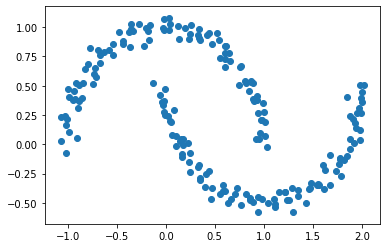

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Zarówno metoda $k$-średnich jak i grupowanie hierarchiczne nie są w stanie pogrupować danych w taki sposób aby każdy księżyc przypisany był do osobnego klastra. 

In [ ]:
km = KMeans(n_clusters=2, random_state=0)
y = km.fit_predict(X)
for i in np.unique(y):
    plt.scatter(X[y == i, 0], X[y == i, 1], marker='o', s=40, edgecolor='black', label='Grupa %s' % (i+1))

plt.title('k-średnich')
plt.legend()
plt.show()


ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y = ac.fit_predict(X)
for i in np.unique(y):
    plt.scatter(X[y == i, 0], X[y == i, 1], marker='o', s=40, edgecolor='black', label='Grupa %s' % (i+1))

plt.legend()
plt.title('Grupowanie hierarchiczne')
plt.show()



Zobaczmy jak poradzi sobie metoda DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y = db.fit_predict(X)

for i in np.unique(y):
    plt.scatter(X[y == i, 0], X[y == i, 1], marker='o', s=40, edgecolor='black', label='Grupa id=%s' % i)

plt.legend()
plt.show()

Dobór parametrów metody nie jest prostym zadaniem. Zobaczmy co się stanie, gdy zmniejszymy promień `eps`.

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.14, min_samples=5, metric='euclidean')
y = db.fit_predict(X)

for i in np.unique(y):
    plt.scatter(X[y == i, 0], X[y == i, 1], marker='o', s=40, edgecolor='black', label='Grupa %s' % i)

plt.legend()
plt.show()

Wykryte zostały 3 grupy (0, 1, 2). Przypadki oznaczone etykietą `y=-1` to wektory oznaczone jako szum. 

## Zadanie - Grupowanie zwierząt

Wykonaj analizę skupień dla zbioru danych `zoo`. Plik z danymi znajduje się pod adresem https://www.fizyka.umk.pl/~grochu/wdm/files/zoo_nc.csv i jest zgodny z formatem CSV.

Dane zawierają 101 przypadków zwierząt opisanych 17 zmiennymi:
- pierwsza kolumna `animal_name` to nazwa zwierzaka
- 15 zmiennych ma wartości binarne oznaczające występowanie danej cechy u zwierzęcia, np. `hair`, `feathers`, `eggs`, `milk`, itd. 
- zmienna `legs` określa ilość nóg i posiada wartości od 0 do 8


1. Wczytaj dane i przygotuj zbiór treningowy według poniższych instrukcji:
  - zmienna `animal_name` zawiera nazwy zwierząt, usuń ją z danych, gdyż nie będzie używana do budowania modelu klasteryzaji
  - zmienna `legs` posiada wartości z zakresu 0-8, które znacznie odbiegają od zakresu pozostałych zmiennych, co może mocno zabuzyć wyniki. Przeskaluj tą zmienną w taki sposób aby jej wartości mieściły się w zakresie od 0 do 1
  - sprawdź, czy w danych są brakujące wartości i jeżeli zajdzie potrzeba usuń przypadki z brakami. Jeżeli w danych zauwazysz inne anomalie (dane odstające lub oczywiste błedy) to zadbaj o to aby się ich pozbyć lub znowelowac ich negatywny wpływ na wynik dalszej analizy.  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('https://www.fizyka.umk.pl/~grochu/wdm/files/zoo_nc.csv')

df_train = df.drop(columns = "animal_name")

min_max_scaler = MinMaxScaler()

df_train[["legs"]] = min_max_scaler.fit_transform(df_train[["legs"]])

df_train.isnull().values.any()

print(df_train)

     hair  feathers  eggs  milk  airborne  ...  fins  legs  tail  domestic  catsize
0       1         0     0     1         0  ...     0  0.50     0         0        1
1       1         0     0     1         0  ...     0  0.50     1         0        1
2       0         0     1     0         0  ...     1  0.00     1         0        0
3       1         0     0     1         0  ...     0  0.50     0         0        1
4       1         0     0     1         0  ...     0  0.50     1         0        1
..    ...       ...   ...   ...       ...  ...   ...   ...   ...       ...      ...
96      1         0     0     1         0  ...     0  0.25     1         0        1
97      1         0     1     0         1  ...     0  0.75     0         0        0
98      1         0     0     1         0  ...     0  0.50     1         0        1
99      0         0     1     0         0  ...     0  0.00     0         0        0
100     0         1     1     0         1  ...     0  0.25     1         0  

2. Wykonaj analizę skupień w celu znalezienia naturalnych grup w zbiorze zwierząt. Wybierz JEDNĄ z podanych niżej metod:
  1. Metoda k-średnich - wyznacz optymalną ilość klastrów za pomocą metody łokcia 
  2. Grupowanie hierarchiczne metodą łączenia zupełnego lub metodą połączeń średnich. Zbuduj model i wyrysuj dendrogram. Na podstawie dendrogramu wybierz miejsce podziału, które wyodrębni istotne skupiska danych.
  3. Metoda DBSCAN - dobierz promień tak aby uzyskać nie mniej niż 2 grupy oraz nie więcej niż 7 grup przy jak najmniejszej liczbie szumu. Minimalna liczebność w grupach nie powinna być mniejsza niż 5.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=2, n_init=10)

X = df_train

# dopasowanie modelu do danych
k_means.fit(X)

# położenie centroid
C = k_means.cluster_centers_

# wartość zniekształcenia SSE
SSE = k_means.inertia_

# przypisanie do grup 
y = k_means.fit_predict(X)

for i in range(len(C)):
    plt.scatter(X[y==i, 0], X[y==i, 1] , marker='o', edgecolor='black', s=50, label='Grupa %d' % (i+1))
plt.scatter(C[:, 0], C[:, 1], marker='*', c='red', edgecolor='black', label='Centroidy', s=200)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()




TypeError: ignored

3. Dla znalezionych wybraną metodą skupisk wypisz
  * liczbę zwierząt w każdym klastrze 
  * nazwy zwierząt w każdym klastrze

